In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datetime import datetime

# yahoo Finance API library (useful?)
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as pdr
yf.pdr_override()

Investigate further stocks regarding the chip industry such as TSM as well as final review on currently held stocks to see if they are worth selling or keeping in the final week.

Final Analysis on Chip Industry Stocks

Final Analysis on Other Stocks we have invested.

Anaylsis on Tesla

Total Stocks:

AAPL, AMD, GOOG, GS, NVDA, TSLA, AMZN

In [109]:
cpu_list = ['NVDA', 'INTC','AMD', 'TSM']

comp_list = ['MSFT','GOOG', 'AAPL', 'AMZN']

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

Data is drastically changed from 3 year span to 2 year span

In [74]:
for stock in cpu_list:
    globals()[stock] = yf.download(stock, start, end)

df_nvda = globals()['NVDA']
df_amd = globals()['AMD']
df_intc = globals()['INTC']
df_tsm = globals()['TSM']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [112]:
for stock in comp_list:
    globals()[stock] = yf.download(stock, start, end)

df_msft = globals()['MSFT']
df_goog = globals()['GOOG']
df_aapl = globals()['AAPL']
df_amzn = globals()['AMZN']

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [76]:
globals()['GS'] = yf.download('GS', start, end)
df_gs = globals()['GS'] 

globals()['TSLA'] = yf.download('TSLA', start, end)
df_tsla = globals()['TSLA'] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


#### Model Preparation 

Spreads data to five years instead of three years

In [77]:
def preprocess_data(stock_symbol, epochs=100, batch_size=32, window_size=60):
    # Fetch data
    end = datetime.now()
    start = datetime(end.year - 5, end.month, end.day)
    df = pdr.get_data_yahoo(stock_symbol, start=start, end=end)

    data = df.filter(['Close'])
    dataset = data.values
    training_data_len = int(np.ceil(len(dataset) * .95))

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset)

    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i+window_size])
        y.append(scaled_data[i+window_size])

    X, y = np.array(X), np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Make predictions
    test_data = scaled_data[training_data_len - window_size:, :]
    test_set = []
    for i in range(window_size, len(test_data)):
        test_set.append(test_data[i-window_size:i, 0])

    test_set = np.array(test_set)
    test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1))

    prediction = model.predict(test_set)
    scaled_pred = scaler.inverse_transform(prediction)

    # Prepare results
    valid = data[training_data_len:]
    valid['Predictions'] = scaled_pred

    return df, valid, scaled_pred

### Goldman Sachs Anaylsis 

#### Closing Price

In [135]:
fig = px.line(df_gs, y=['Open', 'Close', 'High', 'Low', 'Adj Close'], title = 'Date vs Stock Prices')
fig.show()

#### Simple Moving Average (SMA)

Text(0.5, 1.0, 'Goldman Sachs Moving Average')

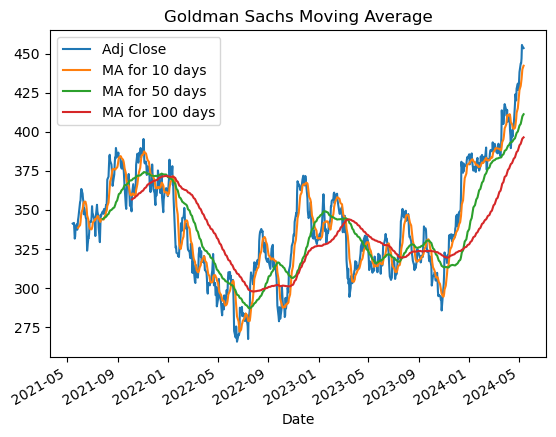

In [79]:
ma_day = [10, 50, 100]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_gs[column_name] = df_gs['Adj Close'].rolling(ma).mean()


df_gs[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Goldman Sachs Moving Average")

### Tesla Analysis 

#### Closing Price

In [136]:
fig = px.line(df_tsla, y=['Open', 'Close', 'High', 'Low', 'Adj Close'], title = 'Date vs Stock Prices')
fig.show()

#### Simple Moving Average (SMA)

Text(0.5, 1.0, 'Tesla Moving Average')

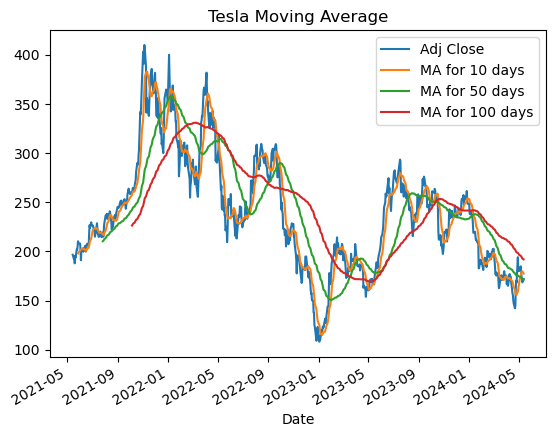

In [81]:
ma_day = [10, 50, 100]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_tsla[column_name] = df_tsla['Adj Close'].rolling(ma).mean()


df_tsla[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Tesla Moving Average")

### Daily Return Calculation - Tesla and Goldman Sachs

In [82]:
daily_close = df_tsla['Adj Close']
daily_pct_tsla = daily_close.pct_change()
daily_pct_tsla.fillna(0,inplace=True)

daily_close = df_gs['Adj Close']
daily_pct_gs = daily_close.pct_change()
daily_pct_gs.fillna(0,inplace=True)

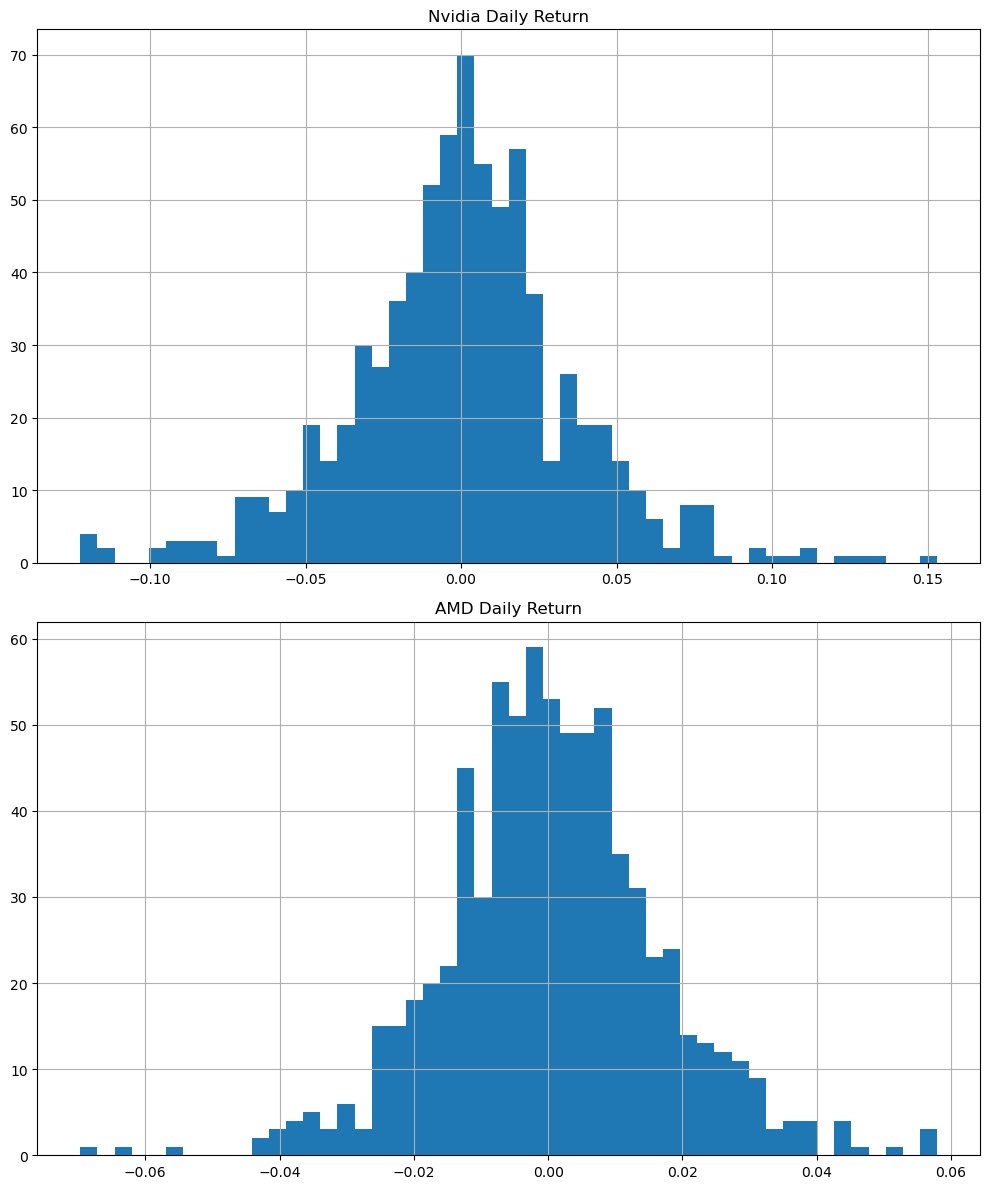

In [83]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

daily_pct_tsla.hist(ax=axs[0], bins=50)
axs[0].set_title('Nvidia Daily Return')

daily_pct_gs.hist(ax=axs[1], bins=50)
axs[1].set_title('AMD Daily Return')

plt.tight_layout()
plt.show()

### Prediction - Tesla & Goldman Sachs

#### Tesla Prediction

In [84]:
df_tsla_5, valid_tsla, pred_tsla = preprocess_data('TSLA')

# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_tsla_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_tsla[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 14ms/step
Hold the stock.


#### Goldman Sachs Prediction

In [85]:
df_gs_5, valid_gs, pred_gs = preprocess_data('GS')

# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_gs_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_gs[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 12ms/step
Hold the stock.


### Conclusion on Investment for Goldman Sachs and Tesla

From what can be seen for Tesla, it is recommended by the prediction model to hold onto any stock we may have. This would make sense due to the downward trend the stock is experiencing. It would make the most sense to hold on to any stock for now. But it is best to wait until the stock reaches a point at or higher than when you bought to make back any losses. Considering its volatility, choosing to purchase an option or to short the stock may be too risky.

Based on the performance of Goldman Sachs, I believe that purchasing an option call for Goldman Sachs considering its notable upward trend that has continued since last week. A bet that the stock will rise is guaranteed. With it moving greater than its average and good daily return.

### Analysis of Chip Industry Companies

In [138]:
# Nvidia, AMD, Intel, TSMC - Chip Analysis
col_nvda = df_nvda['Adj Close']
col_amd = df_amd['Adj Close']
col_intc = df_intc['Adj Close']
col_tsm = df_tsm['Adj Close']

col_df = pd.concat([col_nvda, col_amd, col_intc, col_tsm], axis=1)
col_df.columns = ['NVDA', 'AMD', 'INTC', 'TSM']

#### Performance Summary

In [139]:
fig = px.line(col_df, y=['AMD', 'INTC', 'TSM'], title = 'Closing Prices of Stocks')
fig.show()

#### Individual Performance - TSM

In [98]:
fig_nvda = px.line(df_nvda, y=['Adj Close'], title='Nvidia Stock Performance')

fig_amd = px.line(df_amd, y=['Adj Close'], title='AMD Stock Performance')

fig_intc = px.line(df_intc, y=['Adj Close'], title='Intel Stock Performance')

fig_tsm = px.line(df_tsm, y=['Adj Close'], title='TSM Stock Performance')

# fig_nvda.show()
# fig_amd.show()
# fig_intc.show()
fig_tsm.show()

#### TSM Volatility Data

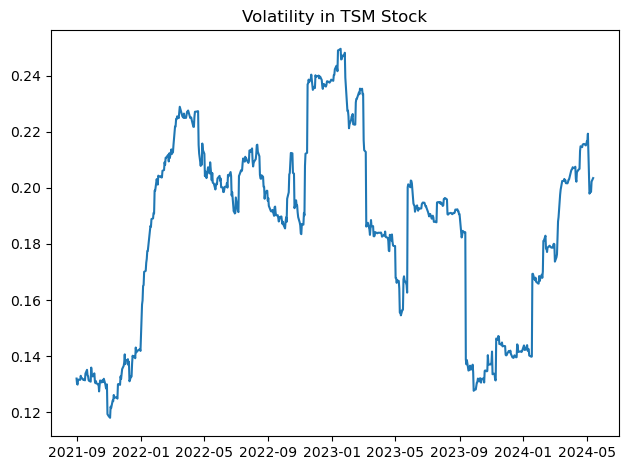

In [133]:
min_periods = 75
vol_tsm = df_tsm['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)

plt.plot(vol_tsm)
plt.title('Volatility in TSM Stock')

plt.tight_layout()
plt.show()

#### Daily Return

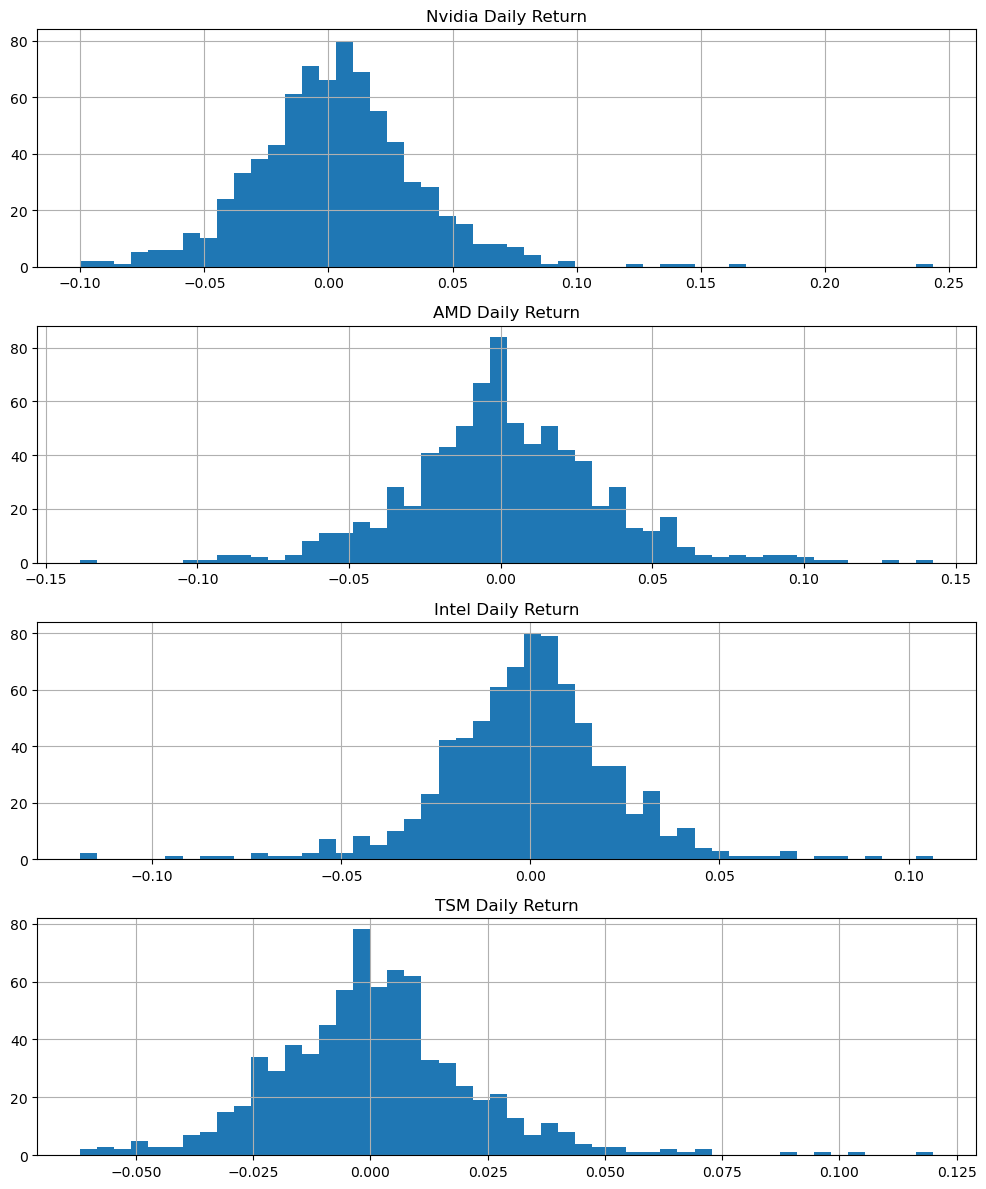

In [132]:
daily_close = df_nvda['Adj Close']
daily_pct_nvda = daily_close.pct_change()
daily_pct_nvda.fillna(0,inplace=True)

daily_close = df_amd['Adj Close']
daily_pct_amd = daily_close.pct_change()
daily_pct_amd.fillna(0,inplace=True)

daily_close = df_intc['Adj Close']
daily_pct_intc = daily_close.pct_change()
daily_pct_intc.fillna(0,inplace=True)

daily_close = df_tsm['Adj Close']
daily_pct_tsm = daily_close.pct_change()
daily_pct_tsm.fillna(0,inplace=True)

fig, axs = plt.subplots(4, 1, figsize=(10, 12))

daily_pct_nvda.hist(ax=axs[0], bins=50)
axs[0].set_title('Nvidia Daily Return')

daily_pct_amd.hist(ax=axs[1], bins=50)
axs[1].set_title('AMD Daily Return')

daily_pct_intc.hist(ax=axs[2], bins=50)
axs[2].set_title('Intel Daily Return')

daily_pct_tsm.hist(ax=axs[3], bins=50)
axs[3].set_title('TSM Daily Return')

plt.tight_layout()
plt.show()

Since the data was reviewed last week, The data would still be closely the same or have very little change. Thus we will focus on if the data of TSM is affected by the other companies of the Chip Industry and if it has a good enough foothold to be invested into.

#### Nvidia Prediction

In [100]:
df_nvda_5, valid_nvda, pred_nvda = preprocess_data(cpu_list[0])

current_price = df_nvda_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_nvda[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 16ms/step
Hold the stock.


#### Intel Prediction

In [101]:
df_intc_5, valid_intc, pred_intc = preprocess_data(cpu_list[1])

current_price = df_intc_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_intc[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 13ms/step
Hold the stock.


#### AMD Prediction

In [102]:
df_amd_5, valid_amd, pred_amd = preprocess_data(cpu_list[2])

current_price = df_amd_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_amd[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 12ms/step
Hold the stock.


#### TSM Prediction

In [103]:
df_tsm_5, valid_tsm, pred_tsm = preprocess_data(cpu_list[3])

current_price = df_tsm_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_tsm[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 14ms/step
Hold the stock.


### Chip Industry Analysis Conclusion

Based on this analysis, I believe TSM (Taiwan Semiconductor Manufacturing) would be a good investment but it would be best to wait for it to drop. Looking at its performance, the stock is very volatile in its rise and fall trends, its daily return shows a less chance to rise compared to other stocks such as AMD or Nvidia that have a 5% daily return chance for rise or drop. Aiming to say that it follows a slower pace of change as compared to the other stocks.

Considering the performance of Intel and in recent news of exports to Huawei Technologies being banned, Intel may be affected negatively from all the problems coming its way. Considering this and Intel's notable downward trend, shorting the stock will be a good course of action due to the belief that Intel's stock will further fall.

### Tech Industry Analysis

Apple, AMD, Google, Amazon

In [141]:
col_msft = df_msft['Adj Close']
col_goog = df_goog['Adj Close']
col_aapl = df_aapl['Adj Close']
col_amzn = df_amzn['Adj Close']

col_df = pd.concat([col_msft,col_goog,col_aapl,col_amzn], axis=1)
col_df.columns = ['MSFT','GOOG', 'AAPL', 'AMZN']

#### Closing Prices

In [142]:
fig = px.line(col_df, y=['MSFT','GOOG', 'AAPL', 'AMZN'], title='Closing Prices of Stocks')
fig.show()

In [143]:
fig = px.line(col_df, y=['GOOG', 'AAPL', 'AMZN'], title='Closing Prices of Stocks')
fig.show()

#### Individual Performance

In [121]:
fig_msft = px.line(df_msft, y=['Adj Close'], title='Microsoft Stock Performance')

fig_goog = px.line(df_intc, y=['Adj Close'], title='Google Stock Performance')

fig_aapl = px.line(df_aapl, y=['Adj Close'], title='Apple Stock Performance')

fig_amzn = px.line(df_amzn, y=['Adj Close'], title='Amazon Stock Performance')

# fig_msft.show()
# fig_goog.show()
# fig_aapl.show()
fig_amzn.show()

#### Simple Moving Average (SMA)

Text(0.5, 1.0, 'Amazon Moving Average')

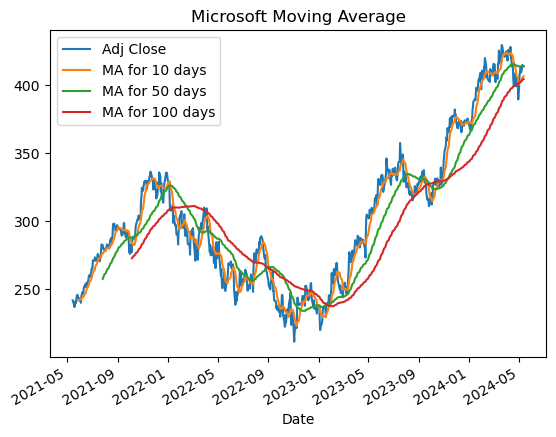

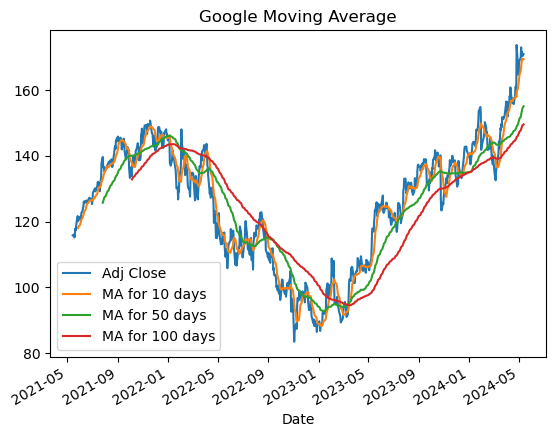

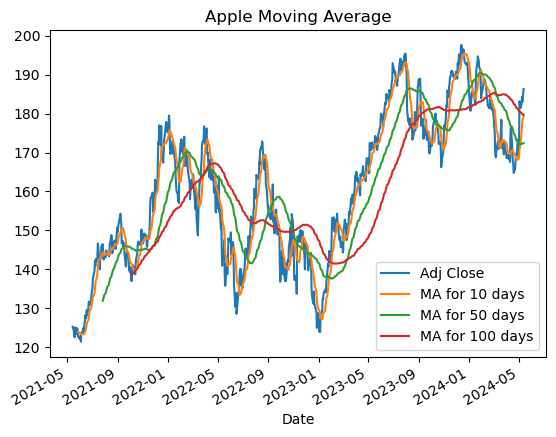

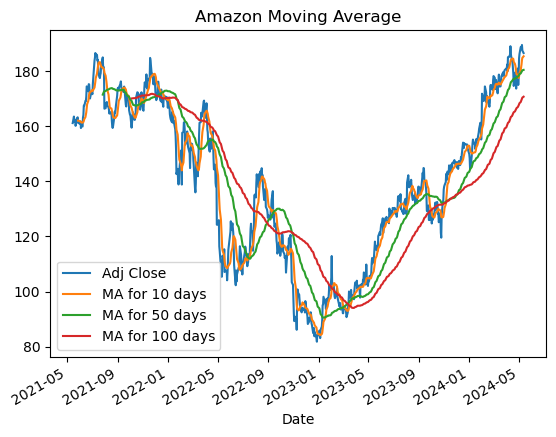

In [144]:
ma_day = [10, 50, 100]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_msft[column_name] = df_msft['Adj Close'].rolling(ma).mean()
    df_goog[column_name] = df_goog['Adj Close'].rolling(ma).mean()
    df_aapl[column_name] = df_aapl['Adj Close'].rolling(ma).mean()
    df_amzn[column_name] = df_amzn['Adj Close'].rolling(ma).mean()

df_msft[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Microsoft Moving Average")

df_goog[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Google Moving Average")

df_aapl[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Apple Moving Average")

df_amzn[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Amazon Moving Average")


#### Volatility Calculation

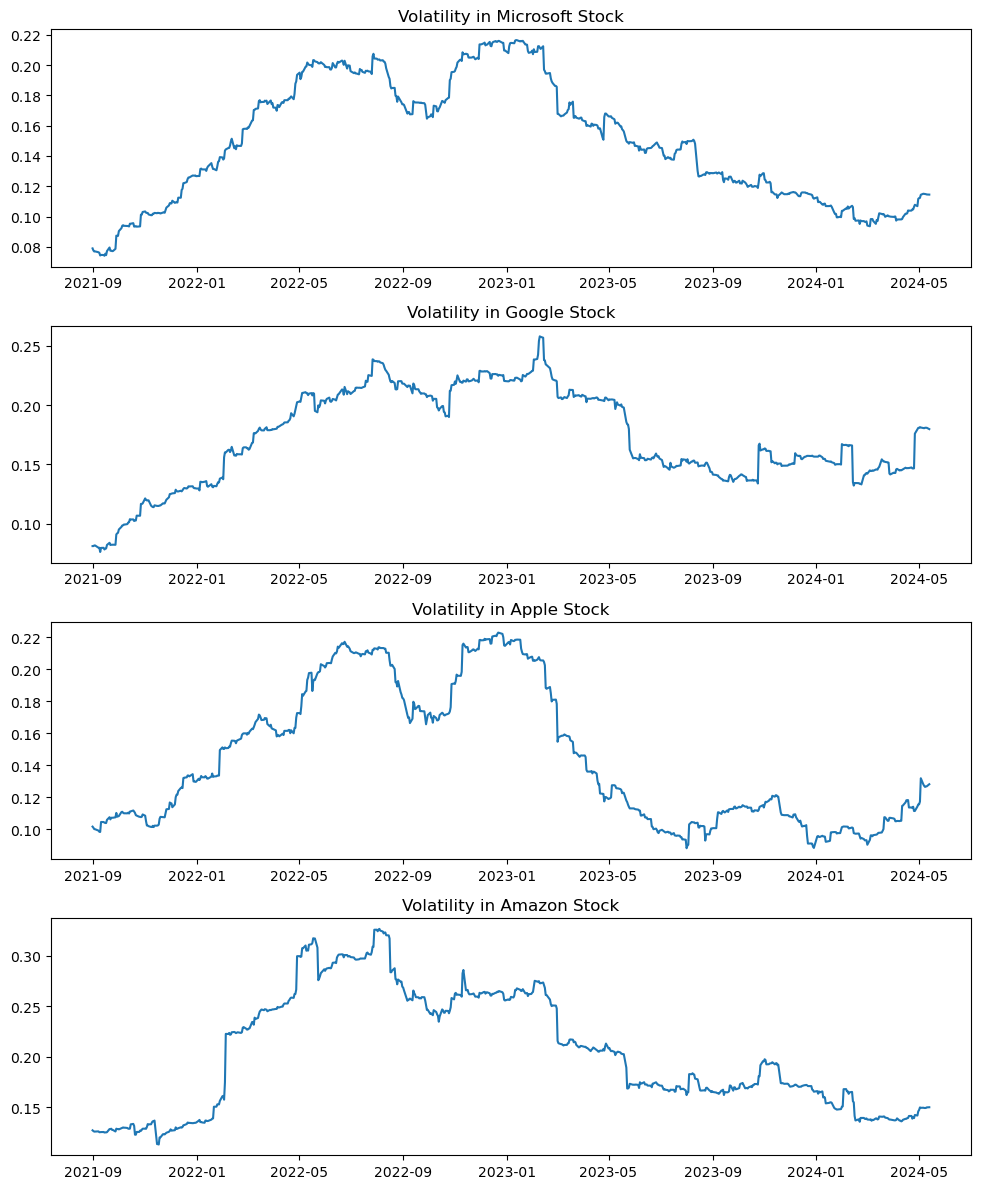

In [124]:
min_periods = 75
vol_amzn = df_amzn['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)

plt.plot(vol_amzn)
plt.title('Volatility in Amazon Stock')

plt.tight_layout()
plt.show()

#### Daily Return 

In [ ]:
daily_close = df_amzn['Adj Close']
daily_pct_amzn = daily_close.pct_change()
daily_pct_amzn.fillna(0,inplace=True)

daily_pct_amzn.hist(ax=axs[3], bins=50, title='Amazon Daily Return')

plt.tight_layout()
plt.show()

#### Prediction

#### Microsoft Stock Prediction

In [125]:
df_msft_5, valid_msft, pred_msft = preprocess_data(comp_list[0])

current_price = df_msft_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_msft[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 15ms/step
Hold the stock.


#### Google Stock Prediction

In [126]:
df_goog_5, valid_goog, pred_goog = preprocess_data(comp_list[1])

current_price = df_goog_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_goog[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 13ms/step
Hold the stock.


#### Apple Stock Prediction

In [127]:
df_aapl_5, valid_aapl, pred_aapl = preprocess_data(comp_list[2])

current_price = df_aapl_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_aapl[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 12ms/step
Hold the stock.


#### Amazon Stock Prediction

In [128]:
df_amzn_5, valid_amzn, pred_amzn = preprocess_data(comp_list[3])

current_price = df_amzn_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_amzn[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 13ms/step
Hold the stock.


### Conclusion for Tech Industry Companies

For Microsoft, it is recommended to hold your stock by the model. 

For Google, it is recommended to hold your stock by the model, I would partly disagree with it and suggest buying a few more stocks regarding this company.

For Apple, it is recommended to hold your stock by the model and I agree with its choice. Since Apple made its recent announcement with the M4 chip, it is recommended to hold your stock to see the outcome of their choice and considering Apple's cult following for its products, there are good reasons to invest and hold now.

For Amazon, it is recommended to hold your stock by the model but I would recommend buying the stock now if you dont have any at the moment. Considering the popularity of Amazon to the general masses and it consistent positive, Amazon can be seen as a "forever" stock. A type of stock will always keep a hold of and watch over many years. Having low volatility with it having a 95% buy rate, Amazon is an safe choice when investing into stocks for the future.

These stocks overall are notable for their long term impact and performance. Seeing them as stocks that will provide notable return in the long term considering these companies are staple companies in the tech industry.

In [ ]:
# total trades: Bought more stock for amazon and google, bought short for Intel